# Generate COCO formatted JSON 
This tutorial is about how to generate the annotation descriptions into COCO formatted json file. 

In [1]:
import os 
import sys 
sys.path.append("./trainer/")
print(sys.path)

['/home/cvipl/CV2020-project_iMaterialist', '/home/cvipl/anaconda3/envs/pytorch_env/lib/python37.zip', '/home/cvipl/anaconda3/envs/pytorch_env/lib/python3.7', '/home/cvipl/anaconda3/envs/pytorch_env/lib/python3.7/lib-dynload', '', '/home/cvipl/anaconda3/envs/pytorch_env/lib/python3.7/site-packages', '/home/cvipl/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/IPython/extensions', '/home/cvipl/.ipython', './trainer/']


In [2]:
import torch 
import torch.nn as nn 
import torch.optim as optim 

import torchvision
from torchvision import datasets, transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torch.optim.lr_scheduler import MultiStepLR

In [3]:
from PIL import Image, ImageFile
import numpy as np 
import pandas as pd 
from pathlib import Path
from tqdm import tqdm, tqdm_notebook

In [4]:
a = np.array([9])
print(type(a))

<class 'numpy.ndarray'>


In [5]:
from DataLoader import Fashion2020dataset

In [6]:
data_dir = Path("../imaterialist-fashion-2020-fgvc7")
df_csv   = Path("../imaterialist-fashion-2020-fgvc7/train.csv")

Dataloader = Fashion2020dataset(root= data_dir, transforms=None, csv_path=df_csv)

In [7]:
Dataloader.root

PosixPath('../imaterialist-fashion-2020-fgvc7')

In [8]:
Dataloader.img_lists

['00000663ed1ff0c4e0132b9b9ac53f6e.jpg',
 '0000fe7c9191fba733c8a69cfaf962b7.jpg',
 '0002ec21ddb8477e98b2cbb87ea2e269.jpg',
 '0002f5a0ebc162ecfb73e2c91e3b8f62.jpg',
 '0004467156e47b0eb6de4aa6479cbd15.jpg',
 '00048c3a2fb9c29340473c4cfc06424a.jpg',
 '0006ea84499fd9a06fefbdf47a5eb4c0.jpg',
 '000775b6b5e27b011dc8bba2d7b85211.jpg',
 '000aac3870ea7c59ca0333ffa5327323.jpg',
 '000b3a87508b0fa185fbd53ecbe2e4c6.jpg',
 '000b3ec2c6eaffb491a5abb72c2e3e26.jpg',
 '000c5bb8ca785bce8d00e3a6c7802a8c.jpg',
 '000c9b4926cd78edd4c19cbc6beba111.jpg',
 '000cd2e13d1bdd28f480304d7bb9e1ca.jpg',
 '000e147149bf33c584afaa953bc198ed.jpg',
 '000e18920575a2e59b3a0c38e6546d29.jpg',
 '000e973c99dc090afd7898c93daf0dbc.jpg',
 '00102686c01fa625aba3b2478f48f415.jpg',
 '001039acb67251508b1b32fd37a49f43.jpg',
 '0010ef2da53cd76ee26122a65f6e76ee.jpg',
 '001657dc6f979869ebf38ea741e90675.jpg',
 '0016d83ce041f39f0a5d94382bf96369.jpg',
 '0017a7bb9e2d8a0f44ce040ed164eea6.jpg',
 '0017af9f7fa8ce9e7558bb924cec324e.jpg',
 '001a66b16b12f1

In [9]:
Dataloader.__len__()

45623

### 객체 슬라이싱과 ```__getitem__```
* [refer to](https://jinmay.github.io/2019/11/26/python/python-instance-slice/)

In [10]:
#img, target = Dataloader.__getitem__(15)
img, target = Dataloader[0]

Image loading: 00000663ed1ff0c4e0132b9b9ac53f6e


In [11]:
img_lists = list(sorted(os.listdir(os.path.join(data_dir, "train2"))))
file_name = target["image_id"]

print(target["image_id"])
print(f"File name is: {file_name}.jpg")

00000663ed1ff0c4e0132b9b9ac53f6e
File name is: 00000663ed1ff0c4e0132b9b9ac53f6e.jpg


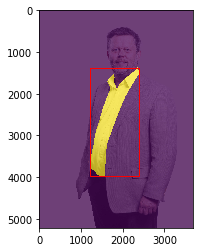

In [12]:
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle

%matplotlib inline 
idx = 1      # _ change the number withing range 
xmin, ymin, xmax, ymax = target["boxes"][idx]

plt.imshow(img)
plt.imshow(target["masks"][idx], alpha=0.7)

plt.gca().add_patch(Rectangle((xmin,ymin),xmax-xmin  , ymax-ymin, linewidth=1,edgecolor='r',facecolor='none'))

***

# Data Preparation for Training 
* We got a total of 45623 training RGB images. 
* Data should be splited into the training and validation set. 
* We need data in the COCO JSON format. 

In [13]:
# _Start: split data into train and validation in a 9:1 ratio
def split_train_validation(data_lists:list):
    img_lists = data_lists
    #print(img_files)
    train_idx = [] 
    val_idx   = [] 
    
    # _Start: split 
#    for i, img_file in enumerate(img_lists): 
    for i, img_file in enumerate(range(80)): 
        if i % 10 == 0: 
            val_idx.append(i)
        else:
            train_idx.append(i)    
    # _End: split 
    
    print(f"Number of training samples: {len(train_idx)}")
    print(f"Number of validation samples: {len(val_idx)}")
    
    return train_idx, val_idx
# _End: split data into train and validation in a 9:1 ratio


train_idx, val_idx = split_train_validation(Dataloader.img_lists)

Number of training samples: 72
Number of validation samples: 8


### Generate COCO formatted JSON 
* [COCO formated json doc](http://cocodataset.org/#format-data)

In [14]:
import json
import pandas as pd
label_ds_json = os.path.join(data_dir, 'label_descriptions.json')


# _Start: get label descriptions from json 
with open(label_ds_json, 'r') as file:
    label_desc = json.load(file)
# _End: get label descriptions  from json 


# _Start: Classes and Attributes processing 
df_categories = pd.DataFrame(label_desc['categories'])
df_attributes = pd.DataFrame(label_desc['attributes'])
# _End: Classes and Attributes processing 

In [15]:
df_categories["name"][0]

'shirt, blouse'

In [16]:
df_categories

,id,name,supercategory,level
0,0,"shirt, blouse",upperbody,2
1,1,"top, t-shirt, sweatshirt",upperbody,2
2,2,sweater,upperbody,2
3,3,cardigan,upperbody,2
4,4,jacket,upperbody,2
5,5,vest,upperbody,2
6,6,pants,lowerbody,2
7,7,shorts,lowerbody,2
8,8,skirt,lowerbody,2
9,9,coat,wholebody,2


In [17]:
import cv2

def get_contour_pts(mask_img):
    mask = mask_img

    assert mask is not None, "mask is empty..."

    ret, thresh = cv2.threshold(mask, 127, 255,  0)

    _, orig_contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_L1)
        
    sorted_contours = [] 
    cnt_area = [] 

    for cnt in orig_contours:
        if len(cnt.shape) == 3 and cnt.shape[1] == 1:
            cnt_area.append(cv2.contourArea(cnt))
            sorted_contours.append(cnt.reshape(-1).tolist())

    contour = [p for p in sorted_contours if len(p) > 4]
    area = [cnt_area[i] for i, p in enumerate(sorted_contours) if len(p)>4]

    return (contour, area)

cnt, area = get_contour_pts(target["masks"][0].numpy())


In [18]:
import json

def generate_COCO_formatted_json(Dataloader:Fashion2020dataset, data_idx:list ,json_filepath:str):
    annotations = []
    images = []
    categories = []
    
    for i, idx in tqdm(enumerate(data_idx), desc="JSON processing..."):
        img, target = Dataloader[idx]
        
        image_filename = '{}.jpg'.format(target["image_id"])

        if len(img.shape) == 3:
            h,w, _ = img.shape
        else:
            h,w = img.shape 
        
        if image_filename not in Dataloader.img_lists:
            continue 
            
        
        for i, mask in enumerate(target["masks"]):
            
            contour, area = get_contour_pts(mask.numpy())
            
            if not contour:
                continue 
                
            xmin, ymin, xmax, ymax = target["boxes"][i] 
            annotations.append({"segmentation": contour,
                                "iscrowd": 0, 
                                "image_id": target["image_id"],
                                "bbox": [xmin, ymin, xmax-xmin, ymax-ymin],
                                "area": area[0],
                                "category_id": target["class_ids"][i],
                                "id": target["image_id"] + str(i) })
            
            categories.append({"supercategory":df_categories["supercategory"][target["class_ids"][i]] ,
                               "id":target["class_ids"][i],
                               "name": df_categories["name"][target["class_ids"][i]]    })
            
        
        images.append({"file_name" : image_filename,
                       "height": h,
                       "width" : w,
                       "id" : target["image_id"]  })
            

    with open(json_filepath, "w") as f:
        json.dump({"images": images, "annotations": annotations, "categories": categories}, f)
        
    return

In [19]:
train_json_path = os.path.join(data_dir, 'train2.json')
validation_json_path = os.path.join(data_dir, 'validation2.json')


# Get train.json in coco format 
generate_COCO_formatted_json(Dataloader= Dataloader,
                             data_idx= train_idx,
                             json_filepath=train_json_path )


# Get validation.json in coco format 
generate_COCO_formatted_json(Dataloader=Dataloader,
                             data_idx= val_idx,
                             json_filepath=validation_json_path)

JSON processing...: 0it [00:00, ?it/s]

Image loading: 0000fe7c9191fba733c8a69cfaf962b7


JSON processing...: 1it [00:01,  1.19s/it]

Image loading: 0002ec21ddb8477e98b2cbb87ea2e269


JSON processing...: 2it [00:03,  1.43s/it]

Image loading: 0002f5a0ebc162ecfb73e2c91e3b8f62
Image loading: 0004467156e47b0eb6de4aa6479cbd15


JSON processing...: 4it [00:03,  1.05s/it]

Image loading: 00048c3a2fb9c29340473c4cfc06424a


JSON processing...: 5it [00:03,  1.14it/s]

Image loading: 0006ea84499fd9a06fefbdf47a5eb4c0


JSON processing...: 6it [00:04,  1.40it/s]

Image loading: 000775b6b5e27b011dc8bba2d7b85211


JSON processing...: 7it [00:05,  1.25it/s]

Image loading: 000aac3870ea7c59ca0333ffa5327323


JSON processing...: 8it [00:17,  4.24s/it]

Image loading: 000b3a87508b0fa185fbd53ecbe2e4c6


JSON processing...: 9it [00:17,  3.08s/it]

Image loading: 000c5bb8ca785bce8d00e3a6c7802a8c


JSON processing...: 10it [00:18,  2.29s/it]

Image loading: 000c9b4926cd78edd4c19cbc6beba111


JSON processing...: 11it [00:18,  1.70s/it]

Image loading: 000cd2e13d1bdd28f480304d7bb9e1ca


JSON processing...: 12it [00:23,  2.57s/it]

Image loading: 000e147149bf33c584afaa953bc198ed


JSON processing...: 13it [00:24,  2.05s/it]

Image loading: 000e18920575a2e59b3a0c38e6546d29


JSON processing...: 14it [00:24,  1.52s/it]

Image loading: 000e973c99dc090afd7898c93daf0dbc


JSON processing...: 15it [00:42,  6.38s/it]

Image loading: 00102686c01fa625aba3b2478f48f415


JSON processing...: 16it [00:43,  4.79s/it]

Image loading: 001039acb67251508b1b32fd37a49f43


JSON processing...: 17it [00:48,  4.87s/it]

Image loading: 0010ef2da53cd76ee26122a65f6e76ee


JSON processing...: 18it [00:57,  6.08s/it]

Image loading: 0016d83ce041f39f0a5d94382bf96369


JSON processing...: 19it [00:57,  4.45s/it]

Image loading: 0017a7bb9e2d8a0f44ce040ed164eea6


JSON processing...: 20it [00:58,  3.26s/it]

Image loading: 0017af9f7fa8ce9e7558bb924cec324e


JSON processing...: 22it [00:59,  1.76s/it]

Image loading: 001a66b16b12f12dc45e2bba40e04683
Image loading: 001b385ce6556a41698fe91297fe2306


JSON processing...: 23it [01:02,  2.26s/it]

Image loading: 001d43443c6b9844df2770508cc51edd


JSON processing...: 24it [01:02,  1.72s/it]

Image loading: 001d7807a696231045860eaee97e825b


JSON processing...: 25it [01:04,  1.71s/it]

Image loading: 002037fce71bdd9046a125e6e7afc0e0


JSON processing...: 26it [01:04,  1.29s/it]

Image loading: 00211c06b1fe730097dde122cd4d3f8c


JSON processing...: 27it [01:05,  1.00it/s]

Image loading: 0024bec9284de7d329da7be884ec74bd


JSON processing...: 28it [01:08,  1.64s/it]

Image loading: 0024cc13c7cd3cf3fc84fdb22bf73a0b


JSON processing...: 29it [01:08,  1.26s/it]

Image loading: 00291c7acf9ec38b6335f805ddb4beb9


JSON processing...: 30it [01:11,  1.81s/it]

Image loading: 002bc82e34205ecf66052749c8ff9e32


JSON processing...: 31it [01:15,  2.39s/it]

Image loading: 002ecdbdc4ebf4b5436388c981025631


JSON processing...: 32it [01:16,  1.82s/it]

Image loading: 002f4f8be328c8c2f105f14613c6c291


JSON processing...: 33it [01:18,  1.95s/it]

Image loading: 0036f906cb15e240f113184b5eed8c69


JSON processing...: 34it [01:18,  1.50s/it]

Image loading: 00375f11809c48821f56051b55b8e8dc


JSON processing...: 35it [01:19,  1.17s/it]

Image loading: 00382465705798a714595f1d043a24e6


JSON processing...: 36it [01:20,  1.32s/it]

Image loading: 0038e8912ece8b5f9d3c520b3fd7ef3b


JSON processing...: 37it [01:21,  1.02s/it]

Image loading: 0039366c35ed742e5bfc6a278b699720


JSON processing...: 38it [01:22,  1.23s/it]

Image loading: 003a6ca3eaa7886da61ed2de2c5e8d27


JSON processing...: 39it [01:30,  3.11s/it]

Image loading: 003ad8a37d2190bd944a8968fb0906e2


JSON processing...: 40it [01:45,  6.64s/it]

Image loading: 003ae3da258f7ba7267af5f159dd3502


JSON processing...: 41it [01:45,  4.81s/it]

Image loading: 003b3e4579833df109d330773418fd65


JSON processing...: 43it [01:48,  2.94s/it]

Image loading: 003c831a9e84ee589d67c4d91786f525
Image loading: 003e4ee955f0a919440714bb6afefb94


JSON processing...: 44it [01:49,  2.49s/it]

Image loading: 0040ad3ac8fdb92067d063a93d9b8d3a


JSON processing...: 45it [01:50,  1.90s/it]

Image loading: 00416e3e6e860ba44984dec14c6d8d4e


JSON processing...: 46it [01:50,  1.42s/it]

Image loading: 0042a243fa1782eb6479da8ae9a869ba


JSON processing...: 47it [01:51,  1.23s/it]

Image loading: 0046079dc059ff3ca36d24d8e2bd7101


JSON processing...: 49it [02:03,  3.23s/it]

Image loading: 00473602960c93da09d4a56c0600a07b
Image loading: 0048f6c47de85cc4dc263912bd0ff6f5


JSON processing...: 50it [02:10,  4.30s/it]

Image loading: 0049efd51c5af1d0ef72144a2cf611dd


JSON processing...: 51it [02:11,  3.35s/it]

Image loading: 004add927302571a7067932d553909e3


JSON processing...: 52it [02:12,  2.58s/it]

Image loading: 004b5c979f9a57c9fbce8bedb3a414aa


JSON processing...: 53it [02:13,  1.92s/it]

Image loading: 004c792b4ab24ecb85dce105bd2e2a79


JSON processing...: 54it [02:13,  1.60s/it]

Image loading: 004ee0031efd4958505d8854cfa136b9


JSON processing...: 55it [02:14,  1.30s/it]

Image loading: 004fb50bd51406759394b2da91a00843


JSON processing...: 56it [02:14,  1.00s/it]

Image loading: 0050bcb3b84397351c1a66659f5e5ca1


JSON processing...: 57it [02:16,  1.09s/it]

Image loading: 00537270eaf902da127c7ac9157a4db1


JSON processing...: 58it [02:25,  3.58s/it]

Image loading: 005380bd939eb68085af3f804d387824


JSON processing...: 59it [02:27,  3.16s/it]

Image loading: 0053bcc20b8c3b62d0302363aa5240e9


JSON processing...: 60it [02:28,  2.37s/it]

Image loading: 0054564ae183ad9a1b152eef0bc11e1d


JSON processing...: 61it [02:28,  1.81s/it]

Image loading: 0054673ece075b3af4c695fc8b8fa237


JSON processing...: 62it [02:28,  1.33s/it]

Image loading: 0055347a114b215f8f469fec9e38c272


JSON processing...: 63it [02:29,  1.08s/it]

Image loading: 00569e580b558c72e43e59fd70e772b5


JSON processing...: 64it [02:29,  1.21it/s]

Image loading: 0056b01990f6e546b395cb51a20f2b44


JSON processing...: 65it [02:30,  1.12it/s]

Image loading: 00573a530f2e9e4c203681547e259f52


JSON processing...: 66it [02:31,  1.29it/s]

Image loading: 0058f13eef5b1a66e42666bbbb834ca9


JSON processing...: 67it [02:31,  1.44it/s]

Image loading: 005cc3138d3afa7236bf4428af165766


JSON processing...: 68it [02:32,  1.76it/s]

Image loading: 005ccdb239e2d6cfe62506dd6eb5693e


JSON processing...: 69it [02:39,  2.63s/it]

Image loading: 005ce89734e3a6b455fed3db373ddb10


JSON processing...: 70it [02:40,  2.14s/it]

Image loading: 005e422d2b6f5fb5fc022b6f65b4acee


JSON processing...: 71it [02:40,  1.60s/it]

Image loading: 005e9b75edcee7d655c390ea5416641d


JSON processing...: 72it [02:41,  2.24s/it]
JSON processing...: 0it [00:00, ?it/s]

Image loading: 00000663ed1ff0c4e0132b9b9ac53f6e


JSON processing...: 1it [00:15, 15.36s/it]

Image loading: 000b3ec2c6eaffb491a5abb72c2e3e26


JSON processing...: 2it [00:17, 11.49s/it]

Image loading: 001657dc6f979869ebf38ea741e90675


JSON processing...: 3it [00:18,  8.39s/it]

Image loading: 00213526750c326a6d8cac9d44b458de


JSON processing...: 4it [00:19,  5.97s/it]

Image loading: 0038d87bdf966bc82cf430f924c1d8c6


JSON processing...: 5it [00:21,  4.98s/it]

Image loading: 0040e5863c5e6197cd264509bc2fbb1c


JSON processing...: 6it [00:27,  5.17s/it]

Image loading: 004dc465c15bb89f419f4e528468ef57


JSON processing...: 7it [00:28,  4.01s/it]

Image loading: 0056447a613cceb08686906bdfa512a2


JSON processing...: 8it [00:29,  3.66s/it]


## COCO Image Viewer 
* [refer to](https://www.immersivelimit.com/tutorials/create-coco-annotations-from-scratch/#create-custom-coco-dataset)

In [20]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np 
import cv2 
import random 
import os 
import json 
import matplotlib.pyplot as plt 

In [21]:
from detectron2.utils.visualizer import Visualizer, ColorMode

from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog

### Register Dataset

In [22]:
train_data_name = 'fashion_train'
val_data_name = 'fashion_val'


register_coco_instances(train_data_name, {}, train_json_path, os.path.join(data_dir, 'train2') )
register_coco_instances(val_data_name, {}, validation_json_path, os.path.join(data_dir, 'train2') )

### Visualize Training Data

WARNING [06/01 19:00:19 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/01 19:00:19 d2.data.datasets.coco]: Loaded 72 images in COCO format from ../imaterialist-fashion-2020-fgvc7/train2.json
Path: ../imaterialist-fashion-2020-fgvc7/train2/000cd2e13d1bdd28f480304d7bb9e1ca.jpg


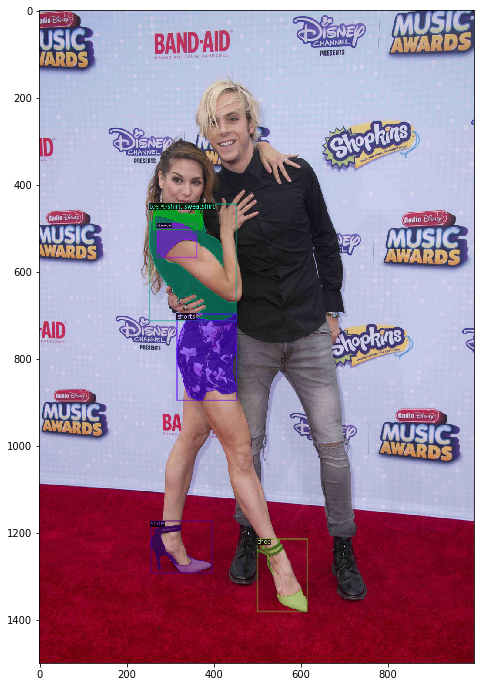

Path: ../imaterialist-fashion-2020-fgvc7/train2/001a66b16b12f12dc45e2bba40e04683.jpg


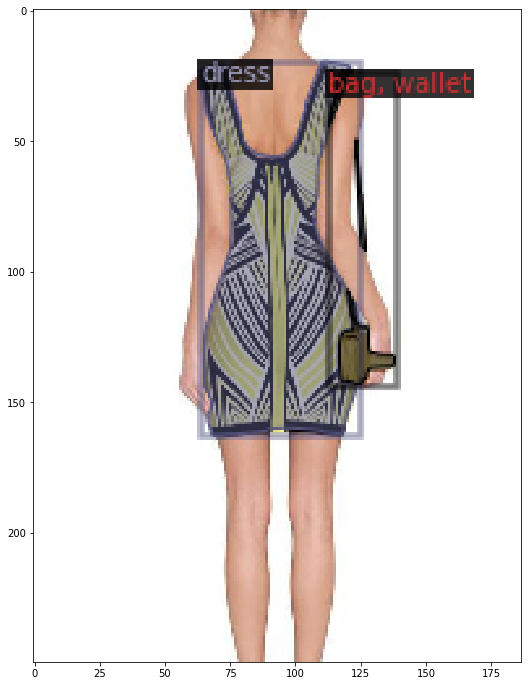

Path: ../imaterialist-fashion-2020-fgvc7/train2/00102686c01fa625aba3b2478f48f415.jpg


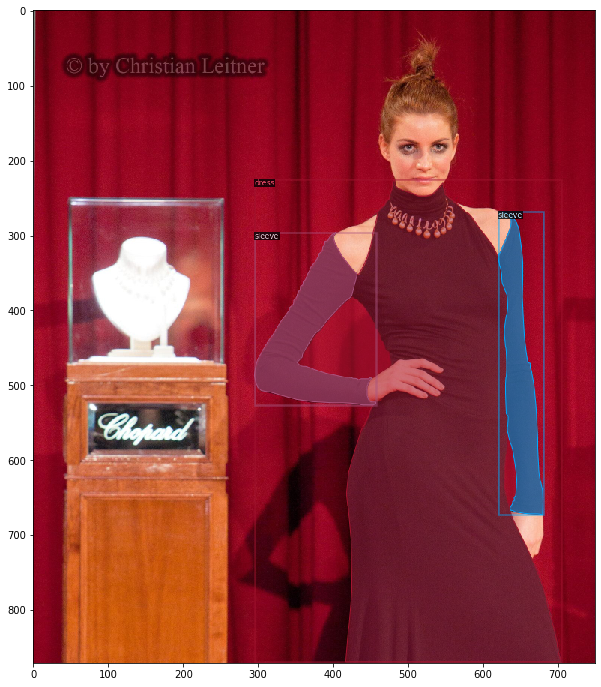

In [23]:
train_metadata = MetadataCatalog.get(train_data_name)

dataset_dicts = DatasetCatalog.get(name=train_data_name)

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    print("Path:",d["file_name"] )
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure(figsize = (12, 12))
    plt.imshow(vis.get_image())
    plt.show()